# Classification: Maximize Precision - Hotels
---
Libraries:

In [1]:
import pandas as pd
import numpy as np
import spacy

from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

import joblib

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

Functions:

In [2]:
# Function For Text Normalization
def clean_text(data):
    urls = r'http\S+'
    non_unicode_char = r'\W'
    numbers = r'[0-9_]'
    fix_whitespace = r'\s+'
    single_whitespace = ' '
    
    data = (data.replace([urls], single_whitespace, regex=True)
                    .replace([non_unicode_char, numbers], single_whitespace, regex=True)
                    .replace(fix_whitespace, single_whitespace, regex=True))
    data = data.apply(lambda s: s.lower() if type(s) == str else s)
    return data

# NLP Functions
nlp_el = spacy.load('el_core_news_md')
nlp_en = spacy.load('en_core_web_sm')
STOPWORDS = set(list(spacy.lang.en.STOP_WORDS) + list(spacy.lang.el.STOP_WORDS))

def remove_stopwords(row):
    row = [str(token) for token in nlp_el(row)]
    return [w for w in row if w not in STOPWORDS]

def tokenize_lemmatize(row):
    return [str(token.lemma_) for token in nlp_el(row)]


Load Dataset:

In [3]:
validation_set = pd.read_csv('../../../../datasets/Hotels/classification/hotels-validation-set.csv')
validation_set = validation_set.replace(np.nan, '')
validation_set.head()

,screen_name,name,description,statuses_count,friends_count,followers_count,recent_100_statuses,hotel
0,SophiaSuites,Sophia Collection Santorini,"Luxury Suites, hotels and villas Santorini com...",513,41,127,"""The tans will fade but the memories will las...",1
1,AnthiMariaApart,AnthiMariaApartments,Anthi Maria Beach Apartments is a self-caterin...,102,25,110,Our fantastic New and Improved abc online web...,1
2,wEndowproject,wEndow project,WEndow Escape Resort & Villas | Tailor-made Ad...,350,344,103,https://t.co/DHuXrG8G6o For those who still d...,1
3,paphotels,paphotels,"The best of Greek hospitality! Follow us, visi...",975,1182,475,@AlbertBourla 💯💯💯💯💯 Happy Easter !!!🐣 @paphot...,1
4,medpalace,Mediterranean Palace,A cozy 5 star hotel in the city center with an...,269,543,381,https://t.co/WPCR6KSnw2 New era!\nNew Brand! ...,1


In [5]:
# Variable to Hold predicted labels 
predictions = pd.DataFrame()
predictions['screen_name'] = validation_set['screen_name']
predictions['true_label'] = validation_set['hotel']

NameError: name 'validation_set' is not defined

# Case 1: Lower threshold
---

In [5]:
def get_text_data_hotel_nd(df):
    df['textdata'] = clean_text(df['name'] + ' ' + df['description'])
    df['textdata'] = df['textdata'].apply(lambda row: tokenize_lemmatize(row))
    df['textdata'] = df['textdata'].apply(lambda row: ' '.join(row))
    df['textdata'] = df['textdata'].apply(lambda row: remove_stopwords(row))
    df['textdata'] = df['textdata'].apply(lambda row: ' '.join(row))
    
    return df.textdata

# Load the model
model_nd = joblib.load('../classifiers/classifier_hotel_nd.sav')


predicted_proba = model_nd.predict_proba(validation_set)

In [6]:
def get_labels(predicted_proba, threshold):
    labels = []
    for proba in predicted_proba[:,1]:
        if proba > threshold:
            labels.append(1)
        else:
            labels.append(0)
    return labels


labels_50 = get_labels(predicted_proba,0.50)
labels_40 = get_labels(predicted_proba,0.40)

In [7]:
from sklearn.metrics import precision_score, recall_score

y_true = validation_set.hotel

y_pred = labels_50
prec_50, rec_50 = precision_score(y_true, y_pred, pos_label=1).round(2), recall_score(y_true, y_pred, pos_label=1).round(2)

y_pred = labels_40
prec_40, rec_40 = precision_score(y_true, y_pred, pos_label=1).round(2), recall_score(y_true, y_pred, pos_label=1).round(2)

y_pred = labels_50
prec_50_others, rec_50_others = precision_score(y_true, y_pred, pos_label=0).round(2), recall_score(y_true, y_pred, pos_label=0).round(2)

y_pred = labels_40
prec_40_others, rec_40_others = precision_score(y_true, y_pred, pos_label=0).round(2), recall_score(y_true, y_pred, pos_label=0).round(2)

---- Metrics for Class Others ----
Threshold= 0.50 --> Precision= 0.86, Recall=1.0
Threshold= 0.40 --> Precision= 0.89, Recall=1.0


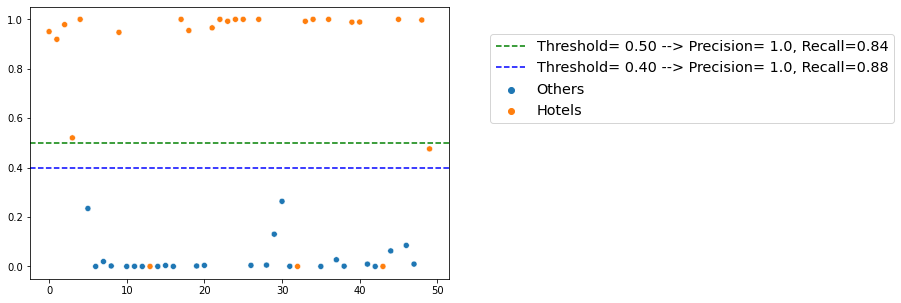

In [8]:
fig, ax = plt.subplots(figsize=[7.5,5])
plot = sns.scatterplot(x=validation_set.index, y = predicted_proba[:,1], hue=validation_set.hotel)
plot.axhline(0.5, ls='--', c='green', label='1')
plot.axhline(0.40, ls='--', c='blue', label='2')

labels = [f'Threshold= 0.50 --> Precision= {prec_50}, Recall={rec_50}',
          f'Threshold= 0.40 --> Precision= {prec_40}, Recall={rec_40}', 
          "Others", 
          "Hotels"]
handles, _ = ax.get_legend_handles_labels()

# Slice list to remove first handle
plt.legend(handles = handles, labels = labels, bbox_to_anchor=(1.1,0.90), loc=2, borderaxespad=0., fontsize='x-large')


print('---- Metrics for Class Others ----')
print(f'Threshold= 0.50 --> Precision= {prec_50_others}, Recall={rec_50_others}')
print(f'Threshold= 0.40 --> Precision= {prec_40_others}, Recall={rec_40_others}')

# Train using class weights

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
import json
import tweepy
import time

from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import FunctionTransformer

from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

import joblib

from sklearn.metrics import precision_score, recall_score

# Function For Text Normalization
def clean_text(data):
    urls = r'http\S+'
    non_unicode_char = r'\W'
    numbers = r'[0-9_]'
    fix_whitespace = r'\s+'
    single_whitespace = ' '
    
    data = (data.replace([urls], single_whitespace, regex=True)
                    .replace([non_unicode_char, numbers], single_whitespace, regex=True)
                    .replace(fix_whitespace, single_whitespace, regex=True))
    data = data.apply(lambda s: s.lower() if type(s) == str else s)
    return data

nlp_el = spacy.load('el_core_news_md')
nlp_en = spacy.load('en_core_web_sm')
STOPWORDS = set(list(spacy.lang.en.STOP_WORDS) + list(spacy.lang.el.STOP_WORDS))

def remove_stopwords(row):
    row = [str(token) for token in nlp_el(row)]
    return [w for w in row if w not in STOPWORDS]

def tokenize_lemmatize(row):
    return [str(token.lemma_) for token in nlp_el(row)]

def tokenize_lemmatize_en(row):
    return [str(token.lemma_) for token in nlp_en(row)]

In [5]:
# Read Training Set
training_set = pd.read_csv('../../../../datasets/Hotels/classification/hotels-training-set.csv', 
                           usecols=['screen_name', 'name', 'description', 'hotel'])
training_set = training_set.replace(np.nan, '')

In [6]:
def get_text_data_hotel_nd(df):
    df = df.copy()
    df['textdata'] = clean_text(df['name'] + ' ' + df['description'])
    df['textdata'] = df['textdata'].apply(lambda row: tokenize_lemmatize(row))
    df['textdata'] = df['textdata'].apply(lambda row: ' '.join(row))
    df['textdata'] = df['textdata'].apply(lambda row: tokenize_lemmatize_en(row))
    df['textdata'] = df['textdata'].apply(lambda row: ' '.join(row))
    df['textdata'] = df['textdata'].apply(lambda row: remove_stopwords(row))
    df['textdata'] = df['textdata'].apply(lambda row: ' '.join(row))
    
    return df.textdata


get_text = FunctionTransformer(get_text_data_hotel_nd)

In [7]:
weights = np.linspace(0.,0.99,100)
weights = [weight.round(4) for weight in weights]
params = [{0:x, 1:(1.0-x).round(4)} for x in weights]

X = training_set
y = training_set['hotel']

def score_fun_rec(estimator, X_test, y_true):
    y_pred = estimator.predict(X_test)
    return recall_score(y_true, y_pred, pos_label=1, zero_division=1)
                        
def score_fun_pre(estimator, X_test, y_true):
    y_pred = estimator.predict(X_test)
    return precision_score(y_true, y_pred, pos_label=1, zero_division=1)                       
                        

precisions = []
recalls = []
ws = []
for param in tqdm(params):
    pipeline = Pipeline([
        ('selector', get_text),
        ('tfidf', TfidfVectorizer(max_df=0.5, max_features=2000, min_df=1)),
        ('svm', svm.SVC(kernel='rbf', C=1, probability=True, class_weight=param))
        ])
    cv_score= cross_validate(pipeline, X, y, cv=3, scoring={'recall':score_fun_rec, 'precision':score_fun_pre})
    prec = cv_score['test_precision'].mean().round(4)
    reca = cv_score['test_recall'].mean().round(4)
    
    precisions.append(prec)
    recalls.append(reca)
    ws.append(param[1])
    print((prec,reca, param))

  0%|          | 0/100 [00:00<?, ?it/s]

(0.5, 1.0, {0: 0.0, 1: 1.0})
(0.5, 1.0, {0: 0.01, 1: 0.99})
(0.5, 1.0, {0: 0.02, 1: 0.98})
(0.5, 1.0, {0: 0.03, 1: 0.97})
(0.5, 1.0, {0: 0.04, 1: 0.96})
(0.5, 1.0, {0: 0.05, 1: 0.95})
(0.5, 1.0, {0: 0.06, 1: 0.94})
(0.5, 1.0, {0: 0.07, 1: 0.93})
(0.5, 1.0, {0: 0.08, 1: 0.92})
(0.5, 1.0, {0: 0.09, 1: 0.91})
(0.5, 1.0, {0: 0.1, 1: 0.9})
(0.5, 1.0, {0: 0.11, 1: 0.89})
(0.5, 1.0, {0: 0.12, 1: 0.88})
(0.5, 1.0, {0: 0.13, 1: 0.87})
(0.5, 1.0, {0: 0.14, 1: 0.86})
(0.5, 1.0, {0: 0.15, 1: 0.85})
(0.5, 1.0, {0: 0.16, 1: 0.84})
(0.5, 1.0, {0: 0.17, 1: 0.83})
(0.5, 1.0, {0: 0.18, 1: 0.82})
(0.5, 1.0, {0: 0.19, 1: 0.81})
(0.5, 1.0, {0: 0.2, 1: 0.8})
(0.5, 1.0, {0: 0.21, 1: 0.79})
(0.5, 1.0, {0: 0.22, 1: 0.78})
(0.5, 1.0, {0: 0.23, 1: 0.77})
(0.5, 1.0, {0: 0.24, 1: 0.76})
(0.5, 1.0, {0: 0.25, 1: 0.75})
(0.5, 1.0, {0: 0.26, 1: 0.74})
(0.5, 1.0, {0: 0.27, 1: 0.73})
(0.5, 1.0, {0: 0.28, 1: 0.72})
(0.5, 1.0, {0: 0.29, 1: 0.71})
(0.5, 1.0, {0: 0.3, 1: 0.7})
(0.5, 1.0, {0: 0.31, 1: 0.69})
(0.5, 1.0, {0: 0

<AxesSubplot:>

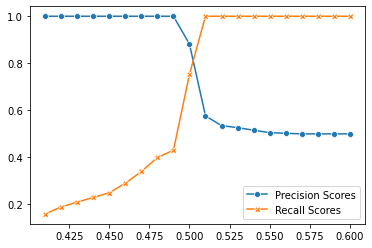

In [9]:
sns.lineplot(x=ws[40:60], y=precisions[40:60], marker = 'o', label='Precision Scores')
sns.lineplot(x=ws[40:60], y=recalls[40:60], marker = 'X', label='Recall Scores')

In [10]:
X = training_set
y = training_set['hotel']

pipeline = Pipeline([
        ('selector', get_text),
        ('tfidf', TfidfVectorizer(max_df=0.5, max_features=2000, min_df=1)),
        ('svm', svm.SVC(kernel='rbf', C=1, probability=True, class_weight={0:1-0.51, 1:0.51}))
        ]).fit(X,y)

In [11]:
y_pred = pipeline.predict(validation_set)

              precision    recall  f1-score   support

   Not-Hotel       0.93      1.00      0.96        25
       Hotel       1.00      0.92      0.96        25

    accuracy                           0.96        50
   macro avg       0.96      0.96      0.96        50
weighted avg       0.96      0.96      0.96        50



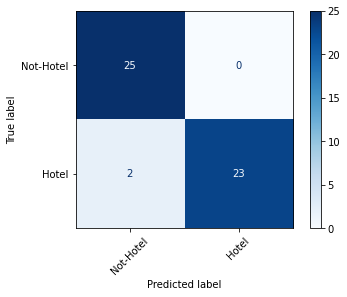

In [12]:
target_names = ['Not-Hotel', 'Hotel']
predicted_labels = pipeline.predict(validation_set)
print(classification_report(y_true = validation_set.hotel, y_pred=predicted_labels, target_names=target_names))
plot_confusion_matrix(pipeline, validation_set, validation_set.hotel, display_labels=target_names, xticks_rotation=45, cmap=plt.cm.Blues)